In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import os
import re
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
pip install --upgrade seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

For my data analysis, I will start by using the set of basic dataframe commands to see what the dataset consists of. 

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Next I will create a simple plot to visualize the data distribution. 

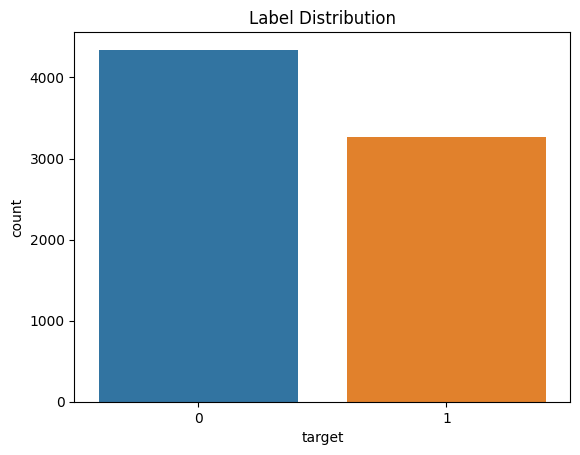

In [6]:
sns.countplot(x='target', data=train)
plt.title('Label Distribution')
plt.show()

Next I will check the unique keywords, and create a countplot to visualize the data separated by label.

<function matplotlib.pyplot.show(close=None, block=None)>

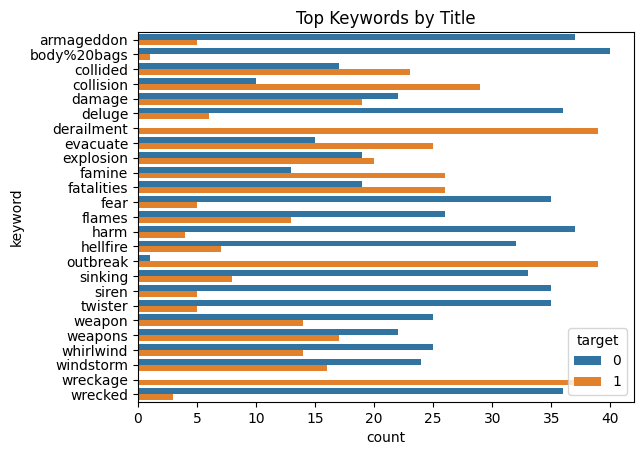

In [7]:
top_keywords = train['keyword'].value_counts().head(25).index
sns.countplot(y='keyword', data=train[train['keyword'].isin(top_keywords)], hue='target')
plt.title('Top Keywords by Title')
plt.show

This definitely shows a few keywords will definitely be useful to help classify one way opr the other.
Next I will see if there are any corelations by location, though there look to be alot of missing location information so I am not as hopeful this will be useful.

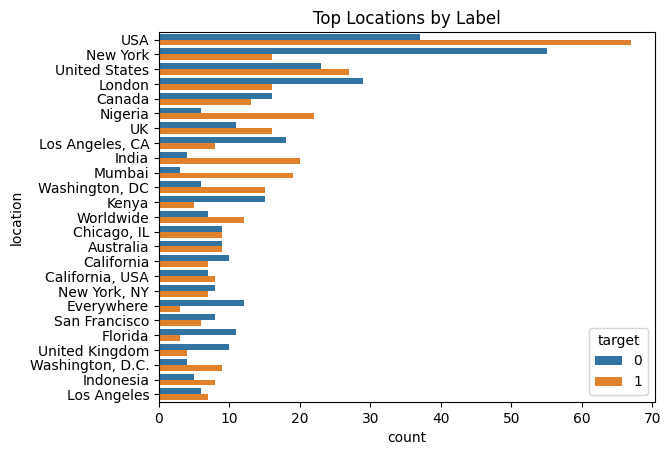

In [8]:
top_locations = train['location'].value_counts().head(25).index
sns.countplot(y='location', data=train[train['location'].isin(top_locations)], hue='target', order=top_locations)
plt.title('Top Locations by Label')
plt.show()

Looks like there will be a few locations that will help to classify, but more even distribution for others.
Next on the list we will see if there is anything that stands out about the text lenth and word counts in the articles. Check to see if longer or shorter tweets are more likely to about disasters. We will need to modify the df to include text length and word counts of each entry.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


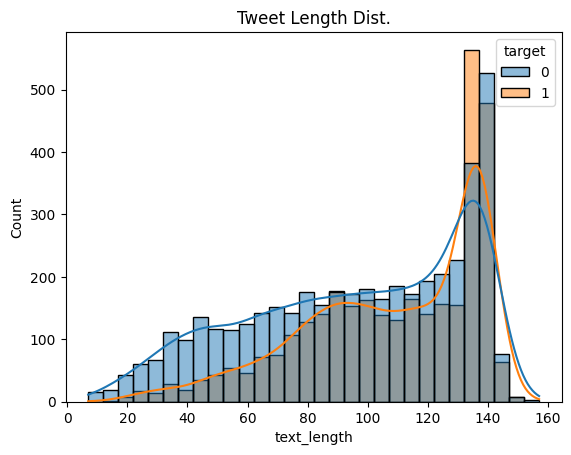

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


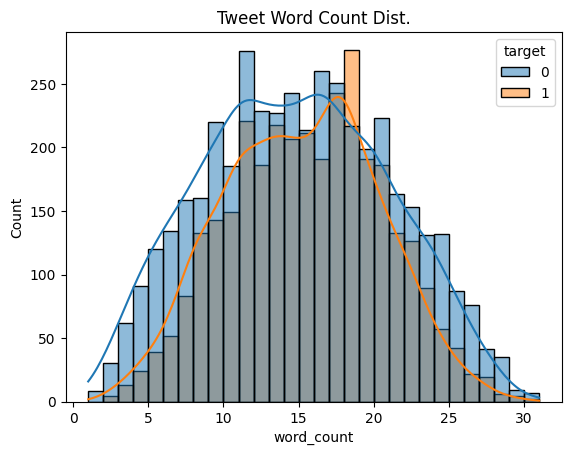

In [9]:
# Add two new columns to the DF for text len and word count
train['text_length'] = train['text'].apply(len)
train['word_count'] = train['text'].apply(lambda x: len(x.split()))
# plot two histograms showing tweet length by label
sns.histplot(data=train, x='text_length', hue='target', kde=True, bins=30)
plt.title('Tweet Length Dist.')
plt.show()
# do the same thing for word counts.
sns.histplot(data=train, x='word_count', hue='target', kde=True, bins=30)
plt.title('Tweet Word Count Dist.')
plt.show()

Nothing that stands out as being teribly useful, but I will try to intergrate this data into the model to see if it helps. Next I will make a word clouds by label tto see if any individual words stand out. 

In [10]:
stop_words = set(stopwords.words('english'))
def generate_cloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

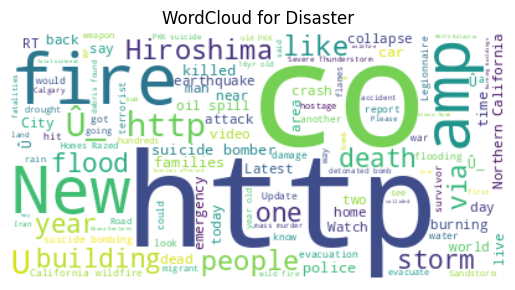

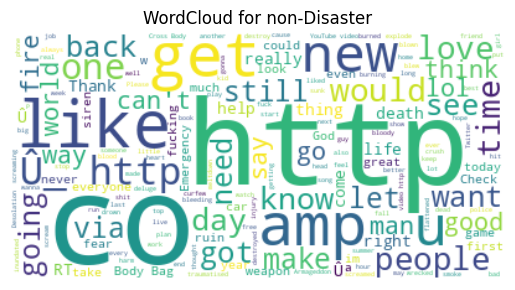

In [11]:
generate_cloud(train[train['target']==1]['text'], "WordCloud for Disaster")
generate_cloud(train[train['target']==0]['text'], "WordCloud for non-Disaster")


After running the initial wordclouds, even after discarding stopwords there are plenty of overlap with some common un-helpful words like http and co. This clearly shows the need for some data cleaning. We will work on that next. Remove as much overlap of common words not removed by stopwords as possible.

In [12]:
# Replace any na keyword values with no_keyword
train['keyword'].fillna('no_keyword', inplace=True)
# Bring all text in the train df text field to lowercase.
train['text'] = train['text'].str.lower()
# Remove URLS, mentions, special chars and numbers from the text
def clean(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train['clean_text'] = train['text'].apply(clean)

/tmp/ipykernel_36/2795813996.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['keyword'].fillna('no_keyword', inplace=True)


Some future warnings for the panda DF in_place method. But still seems to have worked. Will create a new word cloud from the cleaned text to verify. 

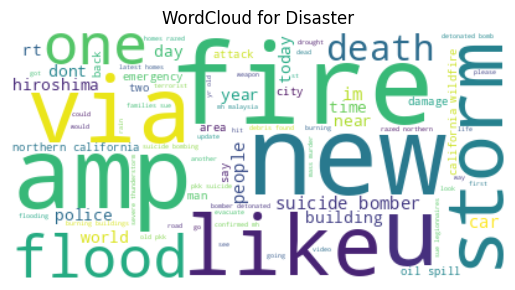

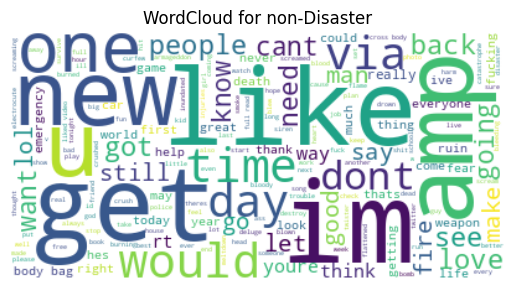

In [13]:
generate_cloud(train[train['target']==1]['clean_text'], "WordCloud for Disaster")
generate_cloud(train[train['target']==0]['clean_text'], "WordCloud for non-Disaster")

In [14]:
train.head()

,id,keyword,location,text,target,text_length,word_count,clean_text
0,1,no_keyword,NaN,our deeds are the reason of this #earthquake m...,1,69,13,deeds reason earthquake may allah forgive us
1,4,no_keyword,NaN,forest fire near la ronge sask. canada,1,38,7,forest fire near la ronge sask canada
2,5,no_keyword,NaN,all residents asked to 'shelter in place' are ...,1,133,22,residents asked shelter place notified officer...
3,6,no_keyword,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,people receive wildfires evacuation orders cal...
4,7,no_keyword,NaN,just got sent this photo from ruby #alaska as ...,1,88,16,got sent photo ruby alaska smoke wildfires pou...


**Model Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

Everything looks good so far. I think I will continue on to the model building. As per the recomendation from the KerasNLP starter notebook I am going to try and load a pretraine BERT model (Bidirectional Encoder Representations from Transformer). The one recomended is the DistilBERT pretrained model from KerasNLP. So to start I will need to import a few new libraries from keras to load the model. 

In [15]:
# installing the required Keras modules needed for the DistilBERT model and preprocessor.
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
os.environ['KERAS_BACKEND'] = 'tensorflow'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.5/876.5 kB 13.3 MB/s eta 0:00:00a 0:00:01


In [16]:
import tensorflow as tf
import keras_core as keras
import keras_hub
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

print('TF version: ', tf.__version__)
print('Keras_hub version: ', keras_hub.__version__)

TF version:  2.18.0
Keras_hub version:  0.18.1


I will create some variables for the training and data preprocessing to make it easier to change the values in one single place rather than having to look through all of the code in the model building section.

In [17]:
# Variable for use in the training split, batch size and epochs for training the model etc...
batch_size = 32
training_size = train.shape[0]
train_split = 0.7
test_split = 0.3
steps_per_epoch = int(training_size) * train_split // batch_size

epochs = 10
AUTO = tf.data.AUTOTUNE

Next I will split the data between a training and validation set using stratify to maintain equal distribution of target values.

In [18]:
train.head()

,id,keyword,location,text,target,text_length,word_count,clean_text
0,1,no_keyword,NaN,our deeds are the reason of this #earthquake m...,1,69,13,deeds reason earthquake may allah forgive us
1,4,no_keyword,NaN,forest fire near la ronge sask. canada,1,38,7,forest fire near la ronge sask canada
2,5,no_keyword,NaN,all residents asked to 'shelter in place' are ...,1,133,22,residents asked shelter place notified officer...
3,6,no_keyword,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,people receive wildfires evacuation orders cal...
4,7,no_keyword,NaN,just got sent this photo from ruby #alaska as ...,1,88,16,got sent photo ruby alaska smoke wildfires pou...


In [19]:
clean_train_df, clean_val_df = train_test_split(
    train, 
    test_size=test_split,
    stratify=train['target'],
    random_state=42
)

# Extract the text and target values from the newly split data for training
X_train = clean_train_df['clean_text']
y_train = clean_train_df['target']
X_val = clean_val_df['clean_text']
y_val = clean_val_df['target']

# print the distributions to verify the data
print('orginal distribution:\n', train['target'].value_counts(normalize=True))
print('train distribution:\n', y_train.value_counts(normalize=True))
print('val distribution:\n', y_val.value_counts(normalize=True))

orginal distribution:
 target
0    0.57034
1    0.42966
Name: proportion, dtype: float64
train distribution:
 target
0    0.570276
1    0.429724
Name: proportion, dtype: float64
val distribution:
 target
0    0.57049
1    0.42951
Name: proportion, dtype: float64


Next I will create new tf datasets from the newly split data.


In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))

train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

After attempting to use the Dataset, I found to many errors, and returned to letting the preprocessor do its job, feeding it the raw dataset.

In [21]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Distributions all look good and new datasets for use in the model have been created and shuffled for the training set. Now I will build the distilBERT pre-processor.

In [22]:
preprocessor = keras_hub.models.DistilBertTextClassifierPreprocessor.from_preset(
    'distil_bert_base_en_uncased',
    sequence_length=160,
    name='preprocessor_4_tweets'
)

Next I will build the distilBERT model from the keras_hub library. 

In [24]:

from tensorflow.keras.optimizers import AdamW

classifier = keras_hub.models.DistilBertTextClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2,
    preprocessor=preprocessor
)

classifier.compile(
    optimizer=AdamW(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


Epoch 1/10


I0000 00:00:1753841993.613974      74 service.cc:148] XLA service 0x7f666c00bdd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753841993.615596      74 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753841993.615616      74 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753841996.197373      74 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753842013.432455      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 ━━━━━━━━━━━━━━━━━━━━ 167s 715ms/step - accuracy: 0.6974 - loss: 0.5835 - val_accuracy: 0.8196 - val_loss: 0.4261
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 599ms/step - accuracy: 0.8275 - loss: 0.4072 - val_accuracy: 0.8157 - val_loss: 0.4231
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 590ms/step - accuracy: 0.8623 - loss: 0.3482 - val_accuracy: 0.8100 - val_loss: 0.4577
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 98s 589ms/step - accuracy: 0.8770 - loss: 0.3043 - val_accuracy: 0.8060 - val_loss: 0.4830
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 589ms/step - accuracy: 0.9009 - loss: 0.2718 - val_accuracy: 0.8218 - val_loss: 0.4777
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 98s 589ms/step - accuracy: 0.9174 - loss: 0.2257 - val_accuracy: 0.8117 - val_loss: 0.5333
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 593ms/step - accuracy: 0.9293 - loss: 0.1974 - val_accuracy: 0.8288 - val_loss: 0.5150
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 590ms/step - accuracy: 0.9381 - loss: 0.1753 - v

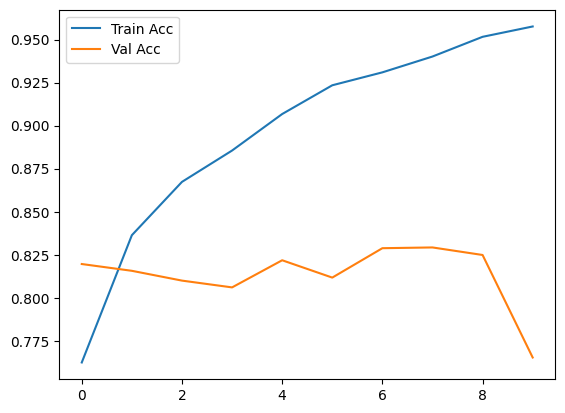

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

**Results and Analysis (35 pts)**

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Major overfitting going on in the model, I will try some hyper parameter tuining next to see if that helps. To start I will try and slow the learning rate by half, and continue from there.

In [26]:

from tensorflow.keras.optimizers import AdamW

classifier = keras_hub.models.DistilBertTextClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2,
    preprocessor=preprocessor
)

classifier.compile(
    optimizer=AdamW(learning_rate=5e-6),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 164s 716ms/step - accuracy: 0.6683 - loss: 0.6212 - val_accuracy: 0.8126 - val_loss: 0.4436
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 597ms/step - accuracy: 0.8092 - loss: 0.4415 - val_accuracy: 0.8249 - val_loss: 0.4242
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 591ms/step - accuracy: 0.8369 - loss: 0.3935 - val_accuracy: 0.8209 - val_loss: 0.4299
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 589ms/step - accuracy: 0.8543 - loss: 0.3592 - val_accuracy: 0.8222 - val_loss: 0.4307
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 591ms/step - accuracy: 0.8684 - loss: 0.3327 - val_accuracy: 0.8209 - val_loss: 0.4540
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 591ms/step - accuracy: 0.8826 - loss: 0.3059 - val_accuracy: 0.8183 - val_loss: 0.4576
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 590ms/step - accuracy: 0.8969 - loss: 0.2796 - val_accuracy: 0.8183 - val_loss: 0.4594
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 596ms/step - accuracy: 0.9077 - loss

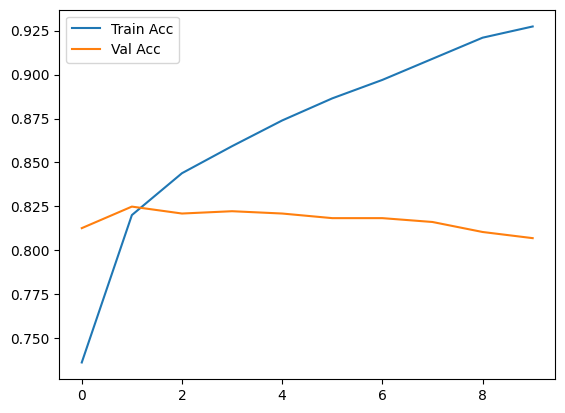

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

This did stabilize the loss, but we are still seeing decay of the validation as the training accuracy continues to climb. Next I will add adjust the decay of the optimizer and add some callbacks for a model checkpoint, an early stopping, and reduce learning rate on plateau

In [29]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

classifier = keras_hub.models.DistilBertTextClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2,
    dropout=0.5,
    preprocessor=preprocessor
)

classifier.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=0.005),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
]

history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=batch_size, 
                         epochs=epochs, 
                         validation_data=(X_val, y_val), 
                         callbacks=callbacks)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 165s 718ms/step - accuracy: 0.6690 - loss: 0.5923 - val_accuracy: 0.8187 - val_loss: 0.4252 - learning_rate: 1.0000e-05
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 98s 587ms/step - accuracy: 0.8275 - loss: 0.4165 - val_accuracy: 0.8240 - val_loss: 0.4126 - learning_rate: 1.0000e-05
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 97s 580ms/step - accuracy: 0.8503 - loss: 0.3609 - val_accuracy: 0.8074 - val_loss: 0.4624 - learning_rate: 1.0000e-05
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 97s 582ms/step - accuracy: 0.8775 - loss: 0.3200 - val_accuracy: 0.7968 - val_loss: 0.5126 - learning_rate: 1.0000e-05
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 99s 591ms/step - accuracy: 0.8879 - loss: 0.2833 - val_accuracy: 0.8240 - val_loss: 0.4666 - learning_rate: 1.0000e-05
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 97s 580ms/step - accuracy: 0.9046 - loss: 0.2534 - val_accuracy: 0.8284 - val_loss: 0.4758 - learning_rate: 1.0000e-05
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 100s 

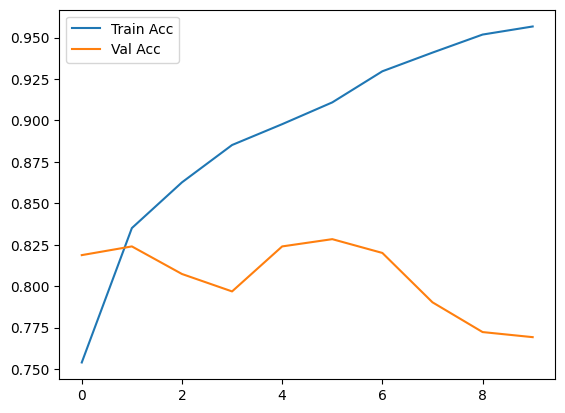

In [30]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

That really didn't help. I think the numbers for the reduce LR need to be adjusted. I am running out of ideas to improve on the numbers. next I will try the callbacks with different numbers, add in a shuffle for the data, and freeze the backbone of the model for coarse training, then recompile with an unlocked bacckbone and fine train at a lower learning rate. Also increase the number of epochs from 10, to 20 for each part of the training.

In [31]:
classifier = keras_hub.models.DistilBertTextClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2,
    preprocessor=preprocessor
)

backbone = classifier.backbone
backbone.trainable = False

classifier.compile(
    optimizer=AdamW(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
]

history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=batch_size, 
                         epochs=20, 
                         validation_data=(X_val, y_val), 
                         callbacks=callbacks,
                         shuffle=True
                        )

backbone.trainable = True

classifier.compile(
    optimizer=AdamW(learning_rate=1e-6),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_history = classifier.fit(x=X_train,
                              y=y_train, 
                              batch_size=batch_size, 
                              epochs=20, 
                              validation_data=(X_val, y_val), 
                              callbacks=callbacks,
                              shuffle=True
                             )


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 318ms/step - accuracy: 0.5738 - loss: 0.6755 - val_accuracy: 0.6961 - val_loss: 0.6298 - learning_rate: 1.0000e-05
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.6941 - loss: 0.6261 - val_accuracy: 0.7701 - val_loss: 0.5768 - learning_rate: 1.0000e-05
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.7453 - loss: 0.5828 - val_accuracy: 0.7837 - val_loss: 0.5358 - learning_rate: 1.0000e-05
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 45s 268ms/step - accuracy: 0.7598 - loss: 0.5469 - val_accuracy: 0.7820 - val_loss: 0.5083 - learning_rate: 1.0000e-05
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - accuracy: 0.7719 - loss: 0.5216 - val_accuracy: 0.7820 - val_loss: 0.4910 - learning_rate: 1.0000e-05
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - accuracy: 0.7752 - loss: 0.5075 - val_accuracy: 0.7837 - val_loss: 0.4800 - learning_rate: 1.0000e-05
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 25

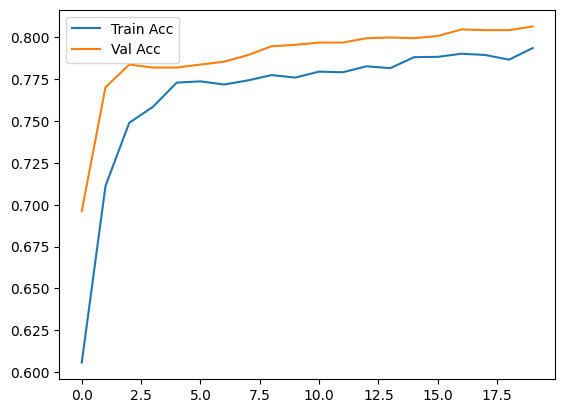

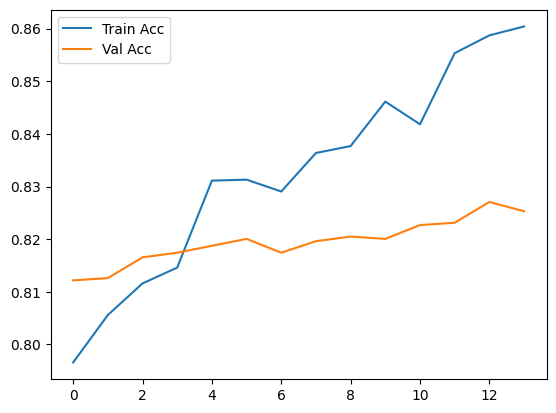

In [32]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.plot(fine_history.history['accuracy'], label='Train Acc')
plt.plot(fine_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

This definitely helped, the curves are stable, especially training with the backbone locked. I will try one last time with similar values, but let the coarse training run until the callback stops it after plateuing. then let the fine training do the same. 300 epochs for the coarse and 100 for the fine aught to do it.

In [34]:
classifier = keras_hub.models.DistilBertTextClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2,
    preprocessor=preprocessor
)

backbone = classifier.backbone
backbone.trainable = False

classifier.compile(
    optimizer=AdamW(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
]

history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=batch_size, 
                         epochs=300, 
                         validation_data=(X_val, y_val), 
                         callbacks=callbacks,
                         shuffle=True
                        )

backbone.trainable = True

classifier.compile(
    optimizer=AdamW(learning_rate=1e-7),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_history = classifier.fit(x=X_train,
                              y=y_train, 
                              batch_size=batch_size, 
                              epochs=100, 
                              validation_data=(X_val, y_val), 
                              callbacks=callbacks,
                              shuffle=True
                             )


Epoch 1/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 327ms/step - accuracy: 0.7264 - loss: 0.5439 - val_accuracy: 0.8043 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 2/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step - accuracy: 0.7822 - loss: 0.4710 - val_accuracy: 0.8091 - val_loss: 0.4407 - learning_rate: 0.0010
Epoch 3/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.7877 - loss: 0.4583 - val_accuracy: 0.8060 - val_loss: 0.4443 - learning_rate: 0.0010
Epoch 4/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 253ms/step - accuracy: 0.7883 - loss: 0.4579 - val_accuracy: 0.8095 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 5/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.7907 - loss: 0.4533 - val_accuracy: 0.7964 - val_loss: 0.4508 - learning_rate: 0.0010
Epoch 6/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 44s 263ms/step - accuracy: 0.7999 - loss: 0.4446 - val_accuracy: 0.8021 - val_loss: 0.4482 - learning_rate: 8.0000e-04
Epoch 7/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 44s 265ms/step - ac

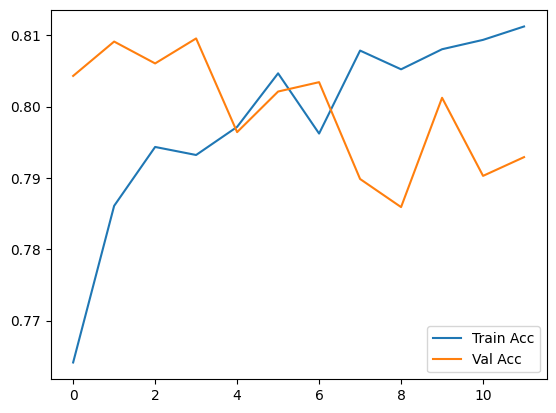

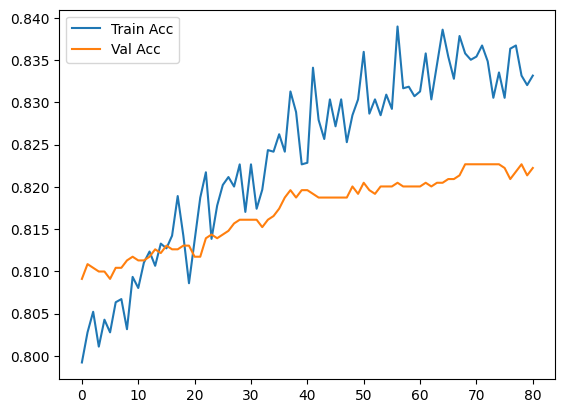

In [35]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.plot(fine_history.history['accuracy'], label='Train Acc')
plt.plot(fine_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

After a much longer training time, using a similar method as before, the coarse training with the backbone locked stoped early after only 12 epochs. Still got some overfitting on the fine tunig with the backbone unlocked, but not nearly as bad as earlier itterations. I am out of time on this project, and after checking the leaderboard, I am not disapointed in the result. 82% is actually pretty good.

Clean the test data the same as the train data so the predictions will be as accurate as possible.

In [38]:
# Replace any na keyword values with no_keyword
test['keyword'].fillna('no_keyword', inplace=True)
# Bring all text in the train df text field to lowercase.
test['text'] = test['text'].str.lower()
# Remove URLS, mentions, special chars and numbers from the text
def clean(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

test['clean_text'] = test['text'].apply(clean)

/tmp/ipykernel_36/340858616.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['keyword'].fillna('no_keyword', inplace=True)


Get y predictions using the model, normalize them, and put tthem into a submission csv.

In [39]:
predictions = classifier.predict(test['clean_text'].values)
pred_labels = np.argmax(predictions, axis=1)
submission = pd.DataFrame({
    'id': test['id'],
    'target': pred_labels
})
submission.to_csv('submission.csv', index=False)
print(submission['target'].value_counts(normalize=True))

102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step
target
0    0.61232
1    0.38768
Name: proportion, dtype: float64


**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

After a lot of testing, and tuning, I was still not able to get the model up above 82% accuracy in training. I will likely still try to use a pretrained model in the future, but I need a lot more practice at testing and tuning them. After making a separate file to load the best_model.keras that was saved from my call backs, I submited and received a the Score: 0.80968, which put me in 360th place. I am actually not to disapointed in that, as very few people scored above .84 (10th place is 85). What did I do to improve the model? Well not as much as I wanted. Straight out of the box, and with a few epochs I was getting close to the same accuracy as my final model. I think locking the backbone in could have helped more, but would have required a lot more training. As it was, the training for this model probaly aproached 15hrs. I did learn some great new ways to work with and save models, and several new hyper parameter tuning methods. I suspect I would have had better improvement working with the data, more than the model. I think this model being specificaly for this purpose, and actually performing really pretty well, I could have better spent my time cleaning and manipulating the data. For next time I will likely try to find all words with similar count in each class, and remove them. Also I think there might be a way to substitute words with similies. Also I think I would try and create a function to shuffle and resplit the data between epochs. All in all, I enjoyed this project, and am happy with the result.